In [1]:
from google.colab import drive
drive.mount('/content/drive')   

Mounted at /content/drive


Import tensorflow and other libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

Use pandas to creat a dataframe

In [3]:
dataframe=pd.read_csv('/content/drive/My Drive/unconventional oil and gas/OG_Compliance.csv')

In [4]:
dataframe['Inspection year']=[i.split('/')[-1] for i in dataframe['INSPECTION_DATE']]

In [5]:
dataframe.head()

,OPERATOR,INSPECTION_ID,INSPECTION_DATE,INSPECTION_TYPE,API_PERMIT,FARM_NAME,UNCONVENTIONAL,SITE_ID,SITE_NAME,FACILITY_TYPE,...,ENFORCEMENT_ID,ENFORCEMENT_CODE_DESCRIPTION,DATE_EXECUTED,ENFORCEMENT_FINAL_DATE,ENFORCEMENT_FINAL_STATUS,PENALTY_FINAL_DATE,PENALTY_FINAL_STATUS_CODE_DESCRIPTION,PENALTY_AMOUNT,TOTAL_AMOUNT_COLLECTED,Inspection year
0,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,239235.0,CACP - Consent Assessment of Civil Penalty,10/20/2008,10/20/2008,Comply/Closed,10/20/2008,COMP - Completed,"$8,400","$8,400",2008
1,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,235597.0,NOV - Notice of Violation,07/07/2008,07/07/2008,Comply/Closed,NaN,NaN,NaN,NaN,2008
2,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,235597.0,NOV - Notice of Violation,07/07/2008,07/07/2008,Comply/Closed,NaN,NaN,NaN,NaN,2008
3,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,239235.0,CACP - Consent Assessment of Civil Penalty,10/20/2008,10/20/2008,Comply/Closed,10/20/2008,COMP - Completed,"$8,400","$8,400",2008
4,AB RESOURCES PA LLC,1712825,06/09/2008,Routine/Complete Inspection,051-23958,AVANTI 1,Yes,702939,AVANTI 1 OG WELL,Oil & Gas Location,...,235597.0,NOV - Notice of Violation,07/07/2008,07/07/2008,Comply/Closed,NaN,NaN,NaN,NaN,2008


In [6]:
dataframe['Inspection year'].value_counts()

2018    19690
2019    19618
2017    16866
2016    15562
2015    13513
2012    13173
2013    12782
2014    11818
2011    11274
2010     6121
2009     2934
2008     1396
2007      205
2006       99
2005       45
2004       26
2003       24
2002       10
2001        4
2000        2
Name: Inspection year, dtype: int64

In [7]:
#清理数据 去除 VIOLATION_CODE 为空的行，只保留原始comment长句大于10个字符的entries
dataframe=dataframe.dropna(subset=['VIOLATION_CODE'])
dataframe=dataframe[dataframe['VIOLATION_CODE'].map(len)>10]
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10440 entries, 0 to 145161
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   OPERATOR                               10440 non-null  object 
 1   INSPECTION_ID                          10440 non-null  int64  
 2   INSPECTION_DATE                        10440 non-null  object 
 3   INSPECTION_TYPE                        10440 non-null  object 
 4   API_PERMIT                             10440 non-null  object 
 5   FARM_NAME                              10440 non-null  object 
 6   UNCONVENTIONAL                         10440 non-null  object 
 7   SITE_ID                                10440 non-null  int64  
 8   SITE_NAME                              10440 non-null  object 
 9   FACILITY_TYPE                          10440 non-null  object 
 10  INSPECTION_CATEGORY                    10440 non-null  object 
 11  R

In [8]:
# 查看分类的个数
dataframe['INSPECTION_RESULT_DESCRIPTION'].value_counts()

Violation(s) Noted                         7486
Outstanding Violations - Viols Req'd       1702
Viol(s) Noted &  Immediately Corrected      975
Violation(s) & Outstanding Violations       175
Violation(s) & Recurring Violations          44
Recurring Violations                         44
Viol(s) Corrected, Viol(s) Noted             10
No Violations Noted                           3
Outstanding Violations - No Viols Req'd       1
Name: INSPECTION_RESULT_DESCRIPTION, dtype: int64

In [9]:
# 重新梳理分类
# 第一个分类：一般违规事故 0
# 第二个分类： 一般违规事故——并立刻改正 1
# 第三个分类： 严重的违规事故 2
# 第四个分类： 反复发生的违规事故 3
name=["Violation(s) Noted","Outstanding Violations - Viols Req'd","Viol(s) Noted &  Immediately Corrected","Violation(s) & Outstanding Violations","Recurring Violations","Violation(s) & Recurring Violations","Viol(s) Corrected, Viol(s) Noted","No Violations Noted","Outstanding Violations - No Viols Req'd"]
title=[0,2,1,2,3,3,1,0,2]
dataframe['label_s']=dataframe['INSPECTION_RESULT_DESCRIPTION'].replace(name,title)

In [10]:
dataframe['label_s'].value_counts()

0    7489
2    1878
1     985
3      88
Name: label_s, dtype: int64

In [11]:
# 利用label 形成掩码数组
mask_array=dataframe['label_s'].values
mask_array.shape

(10440,)

In [12]:
# 创建不同label_severity,label_s的掩码
import numpy.ma as ma

masks_0=ma.masked_greater(mask_array,0).mask #只包含label=0
masks_1=ma.masked_not_equal(mask_array,1).mask #只包含label=1
masks_2=ma.masked_not_equal(mask_array,2).mask #只包含label=2
masks_3=ma.masked_not_equal(mask_array,3).mask #只包含label=3

三层模型对应三个不同数据库。

In [13]:
# 第二个数据库 从违规情况判断违规类型与严重程度
dataframe_ass=dataframe[['OPERATOR','SITE_ID','COUNTY','VIOLATION_CODE','label_s','Inspection year','INSPECTION_COMMENT']]
dataframe_ass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10440 entries, 0 to 145161
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   OPERATOR            10440 non-null  object
 1   SITE_ID             10440 non-null  int64 
 2   COUNTY              10440 non-null  object
 3   VIOLATION_CODE      10440 non-null  object
 4   label_s             10440 non-null  int64 
 5   Inspection year     10440 non-null  object
 6   INSPECTION_COMMENT  7121 non-null   object
dtypes: int64(2), object(5)
memory usage: 652.5+ KB


# 1 第一个数据库

In [14]:
#导入必要的库
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

# 创建Violation dataset，词数1288

In [15]:
violationcode=dataframe_ass['VIOLATION_CODE'].values

In [16]:
violationcode

array(['301CSL - Stream discharge of IW, includes drill cuttings, oil, brine and/or silt',
       '78.56PITCNST - Impoundment not structurally sound, impermeable, 3rd party protected, greater than 20" of seasonal high ground water table',
       '301CSL - Stream discharge of IW, includes drill cuttings, oil, brine and/or silt',
       ...,
       '78.86 - CASING AND CEMENTING - DEFECTIVE CASING OR CEMENTING - Operator failed to report defect in a well that has defective, insufficient or improperly cemented casing to the Department within 24 hours of discovery.  Operator failed to correct defect or failed to submit a plan to correct the defect for approval by the Department within 30 days.',
       '78.86 - CASING AND CEMENTING - DEFECTIVE CASING OR CEMENTING - Operator failed to report defect in a well that has defective, insufficient or improperly cemented casing to the Department within 24 hours of discovery.  Operator failed to correct defect or failed to submit a plan to correct th

In [17]:
#将 inspection comment 进行preprocessing 处理，表示为sentence_seq
def pre_sentence(features):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(features)
  tokenizer_config=tokenizer.get_config()
  #保存字典以便后面画图
  word_counts=json.loads(tokenizer_config['word_counts'])
  index_word=json.loads(tokenizer_config['index_word'])
  word_index=json.loads(tokenizer_config['word_index'])

  #map the sentences to tokens
  sentence_seq=tokenizer.texts_to_sequences(features)

  return word_counts,index_word,word_index,sentence_seq

In [18]:
ass_word,ass_iw,ass_wi,ass_seq=pre_sentence(violationcode)

In [19]:
len(ass_word)

1288

In [20]:
#确定维度最高为128维
ass_ins=pad_sequences(ass_seq,padding='post',maxlen=128)

In [21]:
ass_ins.shape

(10440, 128)

In [22]:
code_np=np.array(ass_ins)
code_np.shape

(10440, 128)

# Inspection comment dataset

In [23]:
inscode=dataframe_ass['INSPECTION_COMMENT'].values.astype(str)

In [24]:
ins_word,ins_iw,ins_wi,ins_seq=pre_sentence(inscode)

In [25]:
len(ins_word)

9779

In [26]:
ins_pd=pad_sequences(ins_seq,padding='post',maxlen=128)
ins_np=np.array(ins_pd)
ins_np.shape

(10440, 128)

# 创建label_s dataset



In [27]:
#构建label的dataset
label_s=dataframe_ass['label_s'].values

In [28]:
label_s

array([0, 0, 0, ..., 2, 2, 2])

In [29]:
len(label_s)

10440

In [30]:
labels_np=np.array(label_s)
labels_np.shape

(10440,)

# 创建couty dataset 大小为（100337，）

outputmode=tf-idf

In [31]:
#构建一个只包含category attribute的dataframe
county=dataframe_ass['COUNTY'].values
county

array(['Fayette', 'Fayette', 'Fayette', ..., 'Clinton', 'Clinton',
       'Clinton'], dtype=object)

In [32]:
# 构建attribute dataset
county_vocab=dataframe_ass["COUNTY"].value_counts()
county_vocab=county_vocab.index
county_vocab

Index(['Lycoming', 'Susquehanna', 'Bradford', 'Tioga', 'Washington', 'Greene',
       'Sullivan', 'Potter', 'Wyoming', 'Westmoreland', 'Somerset',
       'Jefferson', 'Clinton', 'Fayette', 'Clearfield', 'Armstrong', 'Butler',
       'Elk', 'Allegheny', 'Cameron', 'McKean', 'Centre', 'Clarion',
       'Lawrence', 'Forest', 'Beaver', 'Mercer', 'Indiana', 'Blair', 'Venango',
       'Wayne', 'Columbia', 'Warren', 'Erie', 'Crawford', 'Cambria',
       'Huntingdon', 'Bedford'],
      dtype='object')

In [33]:
len(county_vocab)

38

In [34]:
layer1=preprocessing.StringLookup()
layer1.adapt(county)

In [35]:
layer1.get_vocabulary()

['[UNK]',
 'Lycoming',
 'Susquehanna',
 'Bradford',
 'Tioga',
 'Washington',
 'Greene',
 'Sullivan',
 'Potter',
 'Wyoming',
 'Westmoreland',
 'Somerset',
 'Jefferson',
 'Clinton',
 'Fayette',
 'Clearfield',
 'Butler',
 'Armstrong',
 'Elk',
 'Allegheny',
 'Cameron',
 'McKean',
 'Centre',
 'Clarion',
 'Lawrence',
 'Mercer',
 'Indiana',
 'Forest',
 'Beaver',
 'Blair',
 'Wayne',
 'Venango',
 'Warren',
 'Columbia',
 'Erie',
 'Crawford',
 'Cambria',
 'Huntingdon',
 'Bedford']

In [36]:
layer1(county)

<tf.Tensor: shape=(10440,), dtype=int64, numpy=array([14, 14, 14, ..., 13, 13, 13])>

In [37]:
county_cate=layer1(county)

In [38]:
county_np=np.array(county_cate)
county_np=county_np.reshape(-1,1)
county_np.shape

(10440, 1)

In [39]:
county_np

array([[14],
       [14],
       [14],
       ...,
       [13],
       [13],
       [13]])

# 创建SITE_ID dataset 使用cate embedding 的形式




In [40]:
site_id=dataframe_ass['SITE_ID'].values
site_id[:3]

array([702939, 702939, 702939])

In [41]:
layer_site=preprocessing.IntegerLookup()
layer_site.adapt(site_id)
layer_site.get_vocabulary()

[-1,
 736560,
 740459,
 715902,
 733756,
 714919,
 809495,
 786108,
 777109,
 738950,
 785127,
 712876,
 781204,
 814645,
 816699,
 725305,
 722948,
 782772,
 815869,
 698294,
 760464,
 722624,
 739302,
 722723,
 838745,
 722954,
 734718,
 729037,
 693064,
 724559,
 751075,
 743191,
 734464,
 724852,
 691948,
 783514,
 733894,
 715541,
 820712,
 784496,
 710472,
 783869,
 737168,
 824632,
 727361,
 774653,
 739585,
 732600,
 726165,
 784537,
 745363,
 740732,
 735791,
 716461,
 755544,
 753289,
 746724,
 739012,
 735592,
 735270,
 728569,
 761190,
 745721,
 736600,
 734644,
 734551,
 734264,
 729528,
 726414,
 698282,
 763105,
 759644,
 742564,
 741163,
 736566,
 700581,
 788808,
 779510,
 730685,
 728585,
 717351,
 702197,
 748852,
 744430,
 732543,
 730037,
 717225,
 621835,
 822232,
 816352,
 815064,
 772717,
 759921,
 756252,
 734164,
 731599,
 726185,
 725270,
 724022,
 713045,
 712032,
 702939,
 695186,
 788443,
 787638,
 787453,
 759959,
 752674,
 747219,
 737280,
 729390,
 7286

In [42]:
len(layer_site.get_vocabulary())

1676

In [43]:
layer_site(site_id)

<tf.Tensor: shape=(10440,), dtype=int64, numpy=array([101, 101, 101, ..., 155, 155, 155])>

In [44]:
siteid_cat=layer_site(site_id)
siteid_np=np.array(siteid_cat)
siteid_np=siteid_np.reshape(-1,1)
siteid_np

array([[101],
       [101],
       [101],
       ...,
       [155],
       [155],
       [155]])

# 创建 Operator dataset categorical embedding

In [45]:
operator=dataframe_ass['OPERATOR'].values
operator

array(['AB RESOURCES PA LLC', 'AB RESOURCES PA LLC',
       'AB RESOURCES PA LLC', ..., 'XTO ENERGY INC', 'XTO ENERGY INC',
       'XTO ENERGY INC'], dtype=object)

In [46]:
layer3=preprocessing.StringLookup()  
layer3.adapt(operator)
layer3.get_vocabulary()

['[UNK]',
 'RANGE RESOURCES APPALACHIA LLC',
 'CHESAPEAKE APPALACHIA LLC',
 'CHIEF OIL & GAS LLC',
 'CABOT OIL & GAS CORP',
 'EQT PROD CO',
 'REPSOL OIL & GAS USA LLC',
 'SENECA RESOURCES CO LLC',
 'XTO ENERGY INC',
 'EAST RESOURCES INC',
 'SWN PROD CO LLC',
 'PA GEN ENERGY CO LLC',
 'RICE DRILLING B LLC',
 'SWEPI LP',
 'EOG RESOURCES INC',
 'ANADARKO E&P ONSHORE LLC',
 'XPR RESOURCES LLC',
 'WEST TEXAS OPERATING CO LLC D/B/A XTREME ENERGY CO',
 'ROCKDALE MARCELLUS LLC',
 'CHEVRON APPALACHIA LLC',
 'ULTRA RESOURCES INC',
 'ATLAS RESOURCES LLC',
 'SOUTHWESTERN ENERGY PROD CO',
 'CARRIZO (MARCELLUS) LLC',
 'EXCO RESOURCES PA LLC',
 'CNX GAS CO LLC',
 'JKLM ENERGY LLC',
 'INFLECTION ENERGY (PA) LLC',
 'DIVERSIFIED OIL & GAS LLC',
 'ENERGY CORP OF AMER',
 'HILCORP ENERGY CO',
 'J W OPERATING CO',
 'CITRUS ENERGY CORP',
 'EXCO RESOURCES PA INC',
 'NOVUS OPERATING LLC',
 'SNYDER BROS INC',
 'ARD OPR LLC',
 'VANTAGE ENERGY APPALACHIA II LLC',
 'REX ENERGY OPERATING CORP',
 'STONE ENERGY CORP'

In [47]:
len(layer3.get_vocabulary())

108

In [48]:
operator_cat=layer3(operator)
operator_np=np.array(operator_cat)
operator_np=operator_np.reshape(-1,1)
operator_np

array([[56],
       [56],
       [56],
       ...,
       [ 8],
       [ 8],
       [ 8]])

# 创建year category embedding 

In [49]:
year=dataframe_ass['Inspection year'].values.astype(int)
year

array([2008, 2008, 2008, ..., 2019, 2019, 2019])

In [50]:
layer4=preprocessing.IntegerLookup()
layer4.adapt(year)
layer4.get_vocabulary()

[-1,
 2010,
 2011,
 2018,
 2019,
 2017,
 2009,
 2012,
 2013,
 2016,
 2014,
 2015,
 2008,
 2007,
 2006,
 2005,
 2004,
 2001,
 2003,
 2000]

In [51]:
len(layer4.get_vocabulary())

20

In [52]:
year_cat=layer4(year)
year_np=np.array(year_cat)
year_np=year_np.reshape(-1,1)
year_np

array([[12],
       [12],
       [12],
       ...,
       [ 4],
       [ 4],
       [ 4]])

# 区分训练集、验证集、测试集

In [53]:
labelsn_np=pd.get_dummies(labels_np).values

In [54]:
#获取训练集与测试集 test
ins_train,ins_test,code_train,code_test,county_train,county_test,siteid_train,siteid_test,operator_train,operator_test,year_train,year_test,labels_train,labels_test,mlabels_train,mlabels_test=train_test_split(ins_np,code_np,county_np,siteid_np,operator_np,year_np,labelsn_np,labels_np,test_size=0.3,random_state=50)

In [55]:
mlabels_train

array([0, 0, 2, ..., 0, 0, 0])

In [56]:
labels_train

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [57]:
#查看数据条例
print(year_train.shape,"year_train")
print(year_test.shape,"year_test")

(7308, 1) year_train
(3132, 1) year_test


In [58]:
# 创建severity四个集合
# 只包含severity 0类违规事故
year_0=ma.array(year_np,mask=masks_0).compressed()
code_0=ma.array(code_np,mask=masks_0.repeat(128)).compressed()
code_0=np.reshape(code_0,(-1,128))
ins_0=ma.array(ins_np,mask=masks_0.repeat(128)).compressed()
ins_0=np.reshape(ins_0,(-1,128))
county_0=ma.array(county_np,mask=masks_0).compressed()
siteid_0=ma.array(siteid_np,mask=masks_0).compressed()
operator_0=ma.array(operator_np,mask=masks_0).compressed()


#1
year_1=ma.array(year_np,mask=masks_1).compressed()
code_1=ma.array(code_np,mask=masks_1.repeat(128)).compressed()
code_1=np.reshape(code_1,(-1,128))
ins_1=ma.array(ins_np,mask=masks_1.repeat(128)).compressed()
ins_1=np.reshape(ins_1,(-1,128))
county_1=ma.array(county_np,mask=masks_1).compressed()
siteid_1=ma.array(siteid_np,mask=masks_1).compressed()
operator_1=ma.array(operator_np,mask=masks_1).compressed()

#2
year_2=ma.array(year_np,mask=masks_2).compressed()
code_2=ma.array(code_np,mask=masks_2.repeat(128)).compressed()
code_2=np.reshape(code_2,(-1,128))
ins_2=ma.array(ins_np,mask=masks_2.repeat(128)).compressed()
ins_2=np.reshape(ins_2,(-1,128))
county_2=ma.array(county_np,mask=masks_2).compressed()
siteid_2=ma.array(siteid_np,mask=masks_2).compressed()
operator_2=ma.array(operator_np,mask=masks_2).compressed()

#3
year_3=ma.array(year_np,mask=masks_3).compressed()
code_3=ma.array(code_np,mask=masks_3.repeat(128)).compressed()
code_3=np.reshape(code_3,(-1,128))
ins_3=ma.array(ins_np,mask=masks_3.repeat(128)).compressed()
ins_3=np.reshape(ins_3,(-1,128))
county_3=ma.array(county_np,mask=masks_3).compressed()
siteid_3=ma.array(siteid_np,mask=masks_3).compressed()
operator_3=ma.array(operator_np,mask=masks_3).compressed()

# 建立 GRU+ATTENTION

In [59]:
from tensorflow.keras.layers import Embedding,Attention,GRU,Concatenate,Dense,Input,LSTM,Bidirectional,Flatten
from tensorflow.keras import Model

In [60]:
a=np.random.rand(7308,1,5)

In [61]:
a.shape

(7308, 1, 5)

In [62]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_code=Embedding(1289,128,name='violation_code')(input_code) #(batch,128,128)

e_ins=Embedding(9780,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(21,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(109,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1677,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(39,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_code=GRU(128,activation='tanh')(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,128)

e_ins=GRU(128,activation='tanh')(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c]) #(batch,5,128)
contextv,attention_score=Attention()([e_o,concate],return_attention_scores=True)

output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(4,activation='softmax',name='output_severity')(output1)
output1=tf.reshape(output1,[-1,4])

model=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c],
            outputs=[output1,attention_score])

In [63]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [64]:
#确定 metrics
m1=tf.keras.metrics.CategoricalAccuracy()

In [65]:
#使用earlystopping 
early_stopping=tf.keras.callbacks.EarlyStopping(patience=10)

In [66]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_gru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [67]:
#确定优化器、损失函数、准则
model.compile(optimizer='adam',loss=['categorical_crossentropy','binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[m1]) 

In [68]:
#不存储checkpoint
model.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train],y=[labels_train,a],
        callbacks=[early_stopping],
        batch_size=256,
        validation_split=0.1,
        epochs=50)

Epoch 1/50
26/26 [==============================] - 39s 1s/step - loss: 0.9939 - tf.reshape_loss: 0.9939 - attention_loss: 0.9194 - tf.reshape_categorical_accuracy: 0.6953 - attention_categorical_accuracy: 0.1932 - val_loss: 0.7837 - val_tf.reshape_loss: 0.7837 - val_attention_loss: 0.9197 - val_tf.reshape_categorical_accuracy: 0.6990 - val_attention_categorical_accuracy: 0.1792
Epoch 2/50
26/26 [==============================] - 33s 1s/step - loss: 0.6806 - tf.reshape_loss: 0.6806 - attention_loss: 0.9197 - tf.reshape_categorical_accuracy: 0.7544 - attention_categorical_accuracy: 0.2034 - val_loss: 0.5900 - val_tf.reshape_loss: 0.5900 - val_attention_loss: 0.9364 - val_tf.reshape_categorical_accuracy: 0.8181 - val_attention_categorical_accuracy: 0.1984
Epoch 3/50
26/26 [==============================] - 30s 1s/step - loss: 0.4761 - tf.reshape_loss: 0.4761 - attention_loss: 0.9709 - tf.reshape_categorical_accuracy: 0.8239 - attention_categorical_accuracy: 0.1984 - val_loss: 0.5286 - va

In [ ]:
model.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train],y=[labels_train,a],
        callbacks=[early_stopping,cp],
        batch_size=256,
        validation_split=0.1,
        epochs=50)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 1.0047 - tf.reshape_loss: 1.0047 - attention_loss: 0.9194 - tf.reshape_categorical_accuracy: 0.7061 - attention_categorical_accuracy: 0.1975
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_gru/cp-01.ckpt
26/26 [==============================] - 43s 1s/step - loss: 1.0047 - tf.reshape_loss: 1.0047 - attention_loss: 0.9194 - tf.reshape_categorical_accuracy: 0.7061 - attention_categorical_accuracy: 0.1975 - val_loss: 0.8053 - val_tf.reshape_loss: 0.8053 - val_attention_loss: 0.9184 - val_tf.reshape_categorical_accuracy: 0.6990 - val_attention_categorical_accuracy: 0.1819
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.6918 - tf.reshape_loss: 0.6918 - attention_loss: 0.9186 - tf.reshape_categorical_accuracy: 0.7322 - attention_categorical_accuracy: 0.1952
Epoch 00002: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_eva

In [69]:
model.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_gru/cp-06.ckpt')

In [70]:
#测试时间
prediction_s,_=model.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_s,_=model.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])
prediction_s=np.argmax(prediction_s,axis=1)
print("predict severity")
print('precision',precision_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('recall',recall_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('f1score',f1_score(mlabels_test,prediction_s,average='weighted'))

predict severity
precision 0.8778722738509886
********************
recall 0.879948914431673
********************
f1score 0.8756782926071395


In [ ]:
_,w=model_bigru.predict([year_np,code_np,ins_np,operator_np,siteid_np,county_np])

In [ ]:
w.shape

(10440, 1, 5)

In [ ]:
#取 inspection, y s c 的 attention weights
code_weights=w[:,:,0]
ins_weights=w[:,:,1]
year_weights=w[:,:,2] # shape=(63211,1)
site_weights=w[:,:,3]
county_weights=w[:,:,4]

In [ ]:
#统计数值 ins_weights
#最小值
print('code min',np.min(code_weights))
print('ins min',np.min(ins_weights))
print('year min',np.min(year_weights))
print('site min',np.min(site_weights))
print('county min',np.min(county_weights))
#最大值
print('code max',np.max(code_weights))
print('ins max',np.max(ins_weights))
print('year max',np.max(year_weights))
print('site max',np.max(site_weights))
print('county max',np.max(county_weights))
#平均值
print('code mean',np.mean(code_weights))
print('ins mean',np.mean(ins_weights))
print('year mean',np.mean(year_weights))
print('site mean',np.mean(site_weights))
print('county mean',np.mean(county_weights))
#中值
print('code median',np.median(code_weights))
print('inspection median',np.median(ins_weights))
print('year median',np.median(year_weights))
print('site median',np.median(site_weights))
print('county median',np.median(county_weights))
#标准差
print('code std',np.std(code_weights))
print('inspection std',np.std(ins_weights))
print('year std',np.std(year_weights))
print('site std',np.std(site_weights))
print('county std',np.std(county_weights))

code min 0.0022846672
ins min 0.018940356
year min 0.011845894
site min 0.11284482
county min 0.0067952024
code max 0.21505658
ins max 0.55821776
year max 0.4168076
site max 0.9459617
county max 0.25791347
code mean 0.13397881
ins mean 0.21701334
year mean 0.17696106
site mean 0.31275722
county mean 0.15928955
code median 0.13941717
inspection median 0.21328947
year median 0.17934713
site median 0.2868135
county median 0.16611141
code std 0.030742286
inspection std 0.06166264
year std 0.039221846
site std 0.11053949
county std 0.032650527


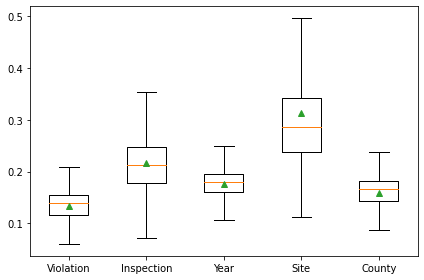

In [ ]:
#绘制attention 箱型图
import matplotlib.pyplot as plt

data=np.concatenate((code_weights,ins_weights,year_weights,site_weights,county_weights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_model2_all.png',dpi=500)

plt.show()

# 视觉展示不同结果的attention weights

In [ ]:
#不要运行此段
year_0=ma.array(year_np,mask=masks_0).compressed()
code_0=ma.array(code_np,mask=masks_0.repeat(128)).compressed()
code_0=np.reshape(code_0,(7489,128))
ins_0=ma.array(ins_np,mask=masks_0.repeat(128)).compressed()
ins_0=np.reshape(ins_0,(7489,128))
county_0=ma.array(county_np,mask=masks_0).compressed()
siteid_0=ma.array(siteid_np,mask=masks_0).compressed()
operator_0=ma.array(operator_np,mask=masks_0).compressed()


#1
year_1=ma.array(year_np,mask=masks_1).compressed()
code_1=ma.array(code_np,mask=masks_1.repeat(128)).compressed()
code_1=np.reshape(code_1,(-1,128))
ins_1=ma.array(ins_np,mask=masks_1.repeat(128)).compressed()
ins_1=np.reshape(ins_1,(-1,128))
county_1=ma.array(county_np,mask=masks_1).compressed()
siteid_1=ma.array(siteid_np,mask=masks_1).compressed()
operator_1=ma.array(operator_np,mask=masks_1).compressed()

#2
year_2=ma.array(year_np,mask=masks_2).compressed()
code_2=ma.array(code_np,mask=masks_2.repeat(128)).compressed()
code_2=np.reshape(code_2,(-1,128))
ins_2=ma.array(ins_np,mask=masks_2.repeat(128)).compressed()
ins_2=np.reshape(ins_2,(-1,128))
county_2=ma.array(county_np,mask=masks_2).compressed()
siteid_2=ma.array(siteid_np,mask=masks_2).compressed()
operator_2=ma.array(operator_np,mask=masks_2).compressed()

#3
year_3=ma.array(year_np,mask=masks_3).compressed()
code_3=ma.array(code_np,mask=masks_3.repeat(128)).compressed()
code_3=np.reshape(code_3,(-1,128))
ins_3=ma.array(ins_np,mask=masks_3.repeat(128)).compressed()
ins_3=np.reshape(ins_3,(-1,128))
county_3=ma.array(county_np,mask=masks_3).compressed()
siteid_3=ma.array(siteid_np,mask=masks_3).compressed()
operator_3=ma.array(operator_np,mask=masks_3).compressed()

In [ ]:
# 模型拟合没有发生过违规事故的数据库
_,weight_0=model_bigru.predict([year_0,code_0,ins_0,operator_0,siteid_0,county_0])

#取 inspection, y s c 的 attention weights
code_novweights=weight_0[:,:,0] 
ins_novweights=weight_0[:,:,1] 
year_novweights=weight_0[:,:,2] 
site_novweights=weight_0[:,:,3]
county_novweights=weight_0[:,:,4]

In [ ]:
#统计数值 
#最小值
print('code min',np.min(code_novweights))
print('inspection min',np.min(ins_novweights))
print('year min',np.min(year_novweights))
print('site min',np.min(site_novweights))
print('county min',np.min(county_novweights))
#平均值
print('code mean',np.mean(code_novweights))
print('inspection mean',np.mean(ins_novweights))
print('year mean',np.mean(year_novweights))
print('site mean',np.mean(site_novweights))
print('county mean',np.mean(county_novweights))

#标准差
print('code std',np.std(code_novweights))
print('inspection std',np.std(ins_novweights))
print('year std',np.std(year_novweights))
print('site std',np.std(site_novweights))
print('county std',np.std(county_novweights))

code min 0.0022846672
inspection min 0.018940356
year min 0.011845894
site min 0.11284482
county min 0.0067952024
code mean 0.12717885
inspection mean 0.22286886
year mean 0.1686169
site mean 0.33149725
county mean 0.14983812
code std 0.03088968
inspection std 0.067608066
year std 0.040993858
site std 0.11832098
county std 0.031770308


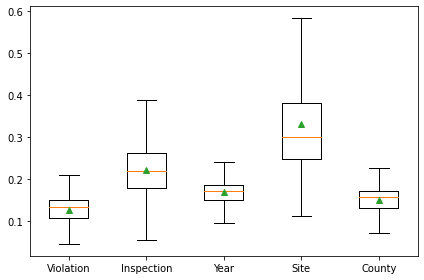

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_novweights,ins_novweights,year_novweights,site_novweights,county_novweights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_model2_s0.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合1
_,weight_1=model_bigru.predict([year_1,code_1,ins_1,operator_1,siteid_1,county_1])

#取 inspection, y s c 的 attention weights
code_novweights=weight_1[:,:,0] 
ins_novweights=weight_1[:,:,1] 
year_novweights=weight_1[:,:,2] 
site_novweights=weight_1[:,:,3]
county_novweights=weight_1[:,:,4]

In [ ]:
#统计数值 
#最小值
print('code min',np.min(code_novweights))
print('inspection min',np.min(ins_novweights))
print('year min',np.min(year_novweights))
print('site min',np.min(site_novweights))
print('county min',np.min(county_novweights))
#平均值
print('code mean',np.mean(code_novweights))
print('inspection mean',np.mean(ins_novweights))
print('year mean',np.mean(year_novweights))
print('site mean',np.mean(site_novweights))
print('county mean',np.mean(county_novweights))

#标准差
print('code std',np.std(code_novweights))
print('inspection std',np.std(ins_novweights))
print('year std',np.std(year_novweights))
print('site std',np.std(site_novweights))
print('county std',np.std(county_novweights))

code min 0.0833157
inspection min 0.123100266
year min 0.11657667
site min 0.14339645
county min 0.09488923
code mean 0.1626247
inspection mean 0.2195367
year mean 0.20550202
site mean 0.22190185
county mean 0.19043474
code std 0.020621112
inspection std 0.03310663
year std 0.026376856
site std 0.043413892
county std 0.014300654


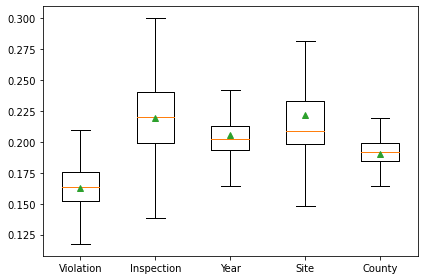

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_novweights,ins_novweights,year_novweights,site_novweights,county_novweights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_model2_s1.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合2
_,weight_2=model_bigru.predict([year_2,code_2,ins_2,operator_2,siteid_2,county_2])

#取 inspection, y s c 的 attention weights
code_novweights=weight_2[:,:,0] 
ins_novweights=weight_2[:,:,1] 
year_novweights=weight_2[:,:,2] 
site_novweights=weight_2[:,:,3]
county_novweights=weight_2[:,:,4]

In [ ]:
#统计数值 
#最小值
print('code min',np.min(code_novweights))
print('inspection min',np.min(ins_novweights))
print('year min',np.min(year_novweights))
print('site min',np.min(site_novweights))
print('county min',np.min(county_novweights))
#平均值
print('code mean',np.mean(code_novweights))
print('inspection mean',np.mean(ins_novweights))
print('year mean',np.mean(year_novweights))
print('site mean',np.mean(site_novweights))
print('county mean',np.mean(county_novweights))

#标准差
print('code std',np.std(code_novweights))
print('inspection std',np.std(ins_novweights))
print('year std',np.std(year_novweights))
print('site std',np.std(site_novweights))
print('county std',np.std(county_novweights))

code min 0.065168224
inspection min 0.0865215
year min 0.09147033
site min 0.17118597
county min 0.08245029
code mean 0.14473714
inspection mean 0.19275483
year mean 0.19397977
site mean 0.28975877
county mean 0.17876947
code std 0.020855024
inspection std 0.03912422
year std 0.02114166
site std 0.06641823
county std 0.021491049


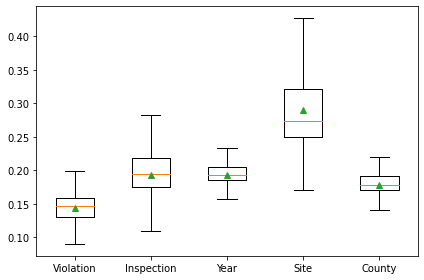

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_novweights,ins_novweights,year_novweights,site_novweights,county_novweights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_model2_s2.png',dpi=500)

plt.show()

In [ ]:
# 模型拟合3
_,weight_3=model_bigru.predict([year_3,code_3,ins_3,operator_3,siteid_3,county_3])

#取 inspection, y s c 的 attention weights
code_novweights=weight_3[:,:,0] 
ins_novweights=weight_3[:,:,1] 
year_novweights=weight_3[:,:,2] 
site_novweights=weight_3[:,:,3]
county_novweights=weight_3[:,:,4]

In [ ]:
#统计数值 
#最小值
print('code min',np.min(code_novweights))
print('inspection min',np.min(ins_novweights))
print('year min',np.min(year_novweights))
print('site min',np.min(site_novweights))
print('county min',np.min(county_novweights))
#平均值
print('code mean',np.mean(code_novweights))
print('inspection mean',np.mean(ins_novweights))
print('year mean',np.mean(year_novweights))
print('site mean',np.mean(site_novweights))
print('county mean',np.mean(county_novweights))

#标准差
print('code std',np.std(code_novweights))
print('inspection std',np.std(ins_novweights))
print('year std',np.std(year_novweights))
print('site std',np.std(site_novweights))
print('county std',np.std(county_novweights))

code min 0.0722576
inspection min 0.12770316
year min 0.15417549
site min 0.197744
county min 0.10306203
code mean 0.16244163
inspection mean 0.20814823
year mean 0.20441203
site mean 0.2257021
county mean 0.19929598
code std 0.021859381
inspection std 0.039213955
year std 0.013658026
site std 0.042504195
county std 0.016453885


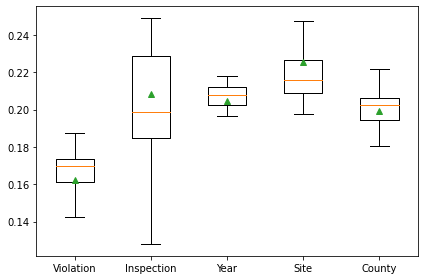

In [ ]:
import matplotlib.pyplot as plt

data=np.concatenate((code_novweights,ins_novweights,year_novweights,site_novweights,county_novweights),axis=1) # shape(63211,4)
plt.boxplot(x=data,sym='',patch_artist=False,showmeans=True,labels=['Violation','Inspection','Year','Site','County'])
plt.tight_layout()
plt.savefig('/content/drive/My Drive/unconventional oil and gas/weight_model2_s3.png',dpi=500)

plt.show()

# LSTM

In [71]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_code=Embedding(1289,128,name='violation_code')(input_code) #(batch,128,128)

e_ins=Embedding(9780,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(21,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(109,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1677,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(39,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_code=LSTM(128,activation='tanh')(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,128)

e_ins=LSTM(128,activation='tanh')(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c]) #(batch,5,128)
contextv,attention_score=Attention()([e_o,concate],return_attention_scores=True)

output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(4,activation='softmax',name='output_severity')(output1)
output1=tf.reshape(output1,[-1,4])

model_lstm=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c],
            outputs=[output1,attention_score])

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_lstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [72]:
#确定优化器、损失函数、准则
model_lstm.compile(optimizer='adam',loss=['categorical_crossentropy','binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[m1]) #3个输出

In [ ]:
model_lstm.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train],y=[labels_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.9764 - tf.reshape_1_loss: 0.9764 - attention_1_loss: 0.9200 - tf.reshape_1_categorical_accuracy: 0.7002 - attention_1_categorical_accuracy: 0.2053
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_lstm/cp-01.ckpt
26/26 [==============================] - 51s 2s/step - loss: 0.9764 - tf.reshape_1_loss: 0.9764 - attention_1_loss: 0.9200 - tf.reshape_1_categorical_accuracy: 0.7002 - attention_1_categorical_accuracy: 0.2053 - val_loss: 0.7841 - val_tf.reshape_1_loss: 0.7841 - val_attention_1_loss: 0.9253 - val_tf.reshape_1_categorical_accuracy: 0.6990 - val_attention_1_categorical_accuracy: 0.1806
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.6746 - tf.reshape_1_loss: 0.6746 - attention_1_loss: 0.9285 - tf.reshape_1_categorical_accuracy: 0.7543 - attention_1_categorical_accuracy: 0.1969
Epoch 00002: saving model to /content/drive/My Drive/unconven

In [74]:
model_lstm.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_lstm/cp-11.ckpt')

In [76]:
prediction_s,_=model_lstm.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
prediction_s,_=model_lstm.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])
prediction_s=np.argmax(prediction_s,axis=1)
print("predict severity")
print('precision',precision_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('recall',recall_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('f1score',f1_score(mlabels_test,prediction_s,average='weighted'))

predict severity
precision 0.8859821369150234
********************
recall 0.8818646232439336
********************
f1score 0.8836392237050875


# BI-GRU

In [77]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_code=Embedding(1289,128,name='violation_code')(input_code) #(batch,128,128)

e_ins=Embedding(9780,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(21,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(109,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1677,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(39,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_code=Bidirectional(GRU(128,activation='tanh'))(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,128)

e_ins=Bidirectional(GRU(128,activation='tanh'))(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c]) #(batch,5,128)
contextv,attention_score=Attention()([e_o,concate],return_attention_scores=True)

output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(4,activation='softmax',name='output_severity')(output1)
output1=tf.reshape(output1,[-1,4])


model_bigru=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c],
            outputs=[output1,attention_score])

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_bigru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [78]:
#确定优化器、损失函数、准则
model_bigru.compile(optimizer='adam',loss=['categorical_crossentropy','binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[m1]) #3个输出

In [79]:
model_bigru.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train],y=[labels_train,a],
          callbacks=[early_stopping],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
26/26 [==============================] - 74s 2s/step - loss: 0.9629 - tf.reshape_2_loss: 0.9629 - attention_2_loss: 0.9167 - tf.reshape_2_categorical_accuracy: 0.6955 - attention_2_categorical_accuracy: 0.2056 - val_loss: 0.7337 - val_tf.reshape_2_loss: 0.7337 - val_attention_2_loss: 0.9176 - val_tf.reshape_2_categorical_accuracy: 0.6990 - val_attention_2_categorical_accuracy: 0.1888
Epoch 2/50
26/26 [==============================] - 62s 2s/step - loss: 0.6002 - tf.reshape_2_loss: 0.6002 - attention_2_loss: 0.9166 - tf.reshape_2_categorical_accuracy: 0.7870 - attention_2_categorical_accuracy: 0.1989 - val_loss: 0.5276 - val_tf.reshape_2_loss: 0.5276 - val_attention_2_loss: 0.9233 - val_tf.reshape_2_categorical_accuracy: 0.8208 - val_attention_2_categorical_accuracy: 0.1984
Epoch 3/50
26/26 [==============================] - 61s 2s/step - loss: 0.3798 - tf.reshape_2_loss: 0.3798 - attention_2_loss: 0.9676 - tf.reshape_2_categorical_accuracy: 0.8486 - attention_2_categorical_

In [ ]:
model_bigru.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train],y=[labels_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.9627 - tf.reshape_2_loss: 0.9627 - attention_2_loss: 0.9184 - tf.reshape_2_categorical_accuracy: 0.6947 - attention_2_categorical_accuracy: 0.1939
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_bigru/cp-01.ckpt
26/26 [==============================] - 80s 3s/step - loss: 0.9627 - tf.reshape_2_loss: 0.9627 - attention_2_loss: 0.9184 - tf.reshape_2_categorical_accuracy: 0.6947 - attention_2_categorical_accuracy: 0.1939 - val_loss: 0.7555 - val_tf.reshape_2_loss: 0.7555 - val_attention_2_loss: 0.9182 - val_tf.reshape_2_categorical_accuracy: 0.6990 - val_attention_2_categorical_accuracy: 0.1833
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.6228 - tf.reshape_2_loss: 0.6228 - attention_2_loss: 0.9179 - tf.reshape_2_categorical_accuracy: 0.7672 - attention_2_categorical_accuracy: 0.1995
Epoch 00002: saving model to /content/drive/My Drive/unconve

In [80]:
model_bigru.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_bigru/cp-06.ckpt')

In [81]:
prediction_s,_=model_bigru.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
prediction_s,_=model_bigru.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])
prediction_s=np.argmax(prediction_s,axis=1)
print("predict severity")
print('precision',precision_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('recall',recall_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('f1score',f1_score(mlabels_test,prediction_s,average='weighted'))

predict severity
precision 0.9147298223021204
********************
recall 0.915389527458493
********************
f1score 0.9146731637191512


# BI-LSTM

In [82]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_code=Embedding(1289,128,name='violation_code')(input_code) #(batch,128,128)

e_ins=Embedding(9780,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(21,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(109,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1677,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(39,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_code=Bidirectional(LSTM(128,activation='tanh'))(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,128)

e_ins=Bidirectional(LSTM(128,activation='tanh'))(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c]) #(batch,5,128)
contextv,attention_score=Attention()([e_o,concate],return_attention_scores=True)

output1=Dense(128,activation='relu')(contextv) #(batch,1,128)
output1=Dense(4,activation='softmax',name='output_severity')(output1)
output1=tf.reshape(output1,[-1,4])

model_bilstm=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c],
            outputs=[output1,attention_score])

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_bilstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [83]:
#确定优化器、损失函数、准则
model_bilstm.compile(optimizer='adam',loss=['categorical_crossentropy','binary_crossentropy'],
              loss_weights=[1,0],
              metrics=[m1]) #3个输出

In [ ]:
model_bilstm.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train],y=[labels_train,a],
          callbacks=[early_stopping,cp],
          batch_size=256,
          validation_split=0.1,
          epochs=50)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.9676 - tf.reshape_3_loss: 0.9676 - attention_3_loss: 0.9204 - tf.reshape_3_categorical_accuracy: 0.6906 - attention_3_categorical_accuracy: 0.2021
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_bilstm/cp-01.ckpt
26/26 [==============================] - 91s 3s/step - loss: 0.9676 - tf.reshape_3_loss: 0.9676 - attention_3_loss: 0.9204 - tf.reshape_3_categorical_accuracy: 0.6906 - attention_3_categorical_accuracy: 0.2021 - val_loss: 0.7412 - val_tf.reshape_3_loss: 0.7412 - val_attention_3_loss: 0.9239 - val_tf.reshape_3_categorical_accuracy: 0.6990 - val_attention_3_categorical_accuracy: 0.1970
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.5807 - tf.reshape_3_loss: 0.5807 - attention_3_loss: 0.9246 - tf.reshape_3_categorical_accuracy: 0.7970 - attention_3_categorical_accuracy: 0.2019
Epoch 00002: saving model to /content/drive/My Drive/unconv

In [85]:
model_bilstm.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_bilstm/cp-05.ckpt')

In [86]:
prediction_s,_=model_bilstm.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
prediction_s,_=model_bilstm.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])
prediction_s=np.argmax(prediction_s,axis=1)
print("predict severity")
print('precision',precision_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('recall',recall_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('f1score',f1_score(mlabels_test,prediction_s,average='weighted'))

predict severity
precision 0.8850027973489638
********************
recall 0.8866538952745849
********************
f1score 0.8822801271084018


# SVM


In [ ]:
from sklearn import svm,metrics

In [ ]:
year_train.shape

(7308, 1)

In [ ]:
operator_train.shape

(7308, 1)

In [ ]:
# 准备数据
x=np.concatenate((year_train,code_train,ins_train,operator_train,siteid_train,county_train),axis=1)
x_test=np.concatenate((year_test,code_test,ins_test,operator_test,siteid_test,county_test),axis=1)

In [ ]:
#观看维度
print("train",x.shape)
print('test',x_test.shape)

train (7308, 260)
test (3132, 260)


In [ ]:
#SVM
clf=svm.SVC()
clf.fit(x,mlabels_train)
predicted_svm=clf.predict(x_test)

In [ ]:
# 指标
print('precision',precision_score(mlabels_test,predicted_svm,average='weighted'))
print('*********************************')
print('recall',recall_score(mlabels_test,predicted_svm,average='weighted'))
print('*********************************')
print('f1',f1_score(mlabels_test,predicted_svm,average='weighted'))

precision 0.8761032077124241
*********************************
recall 0.8588761174968071
*********************************
f1 0.8375752444024356


# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rf=RandomForestClassifier(max_depth=2,random_state=0)
clf_rf.fit(x,mlabels_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
predicted_rf=clf_rf.predict(x_test)

In [ ]:
# 指标
print('precision',precision_score(mlabels_test,predicted_rf,average='weighted'))
print('*********************************')
print('recall',recall_score(mlabels_test,predicted_rf,average='weighted'))
print('*********************************')
print('f1',f1_score(mlabels_test,predicted_rf,average='weighted'))

precision 0.7037683196450102
*********************************
recall 0.7314814814814815
*********************************
f1 0.6238485076425659


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
clf_lr=LogisticRegressionCV(cv=5,random_state=0).fit(x,mlabels_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
predicted_lr=clf_lr.predict(x_test)

In [ ]:
# 指标
print('precision',precision_score(mlabels_test,predicted_lr,average='weighted'))
print('*********************************')
print('recall',recall_score(mlabels_test,predicted_lr,average='weighted'))
print('*********************************')
print('f1',f1_score(mlabels_test,predicted_lr,average='weighted'))

precision 0.7669807471189884
*********************************
recall 0.7905491698595147
*********************************
f1 0.7647952331856684


# Without attention GRU

In [87]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_code=Embedding(1289,128,name='violation_code')(input_code) #(batch,128,128)

e_ins=Embedding(9780,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(21,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(109,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1677,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(39,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_code=GRU(128,activation='tanh')(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,128)

e_ins=GRU(128,activation='tanh')(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_o]) #(batch,6,128)
concate=Flatten()(concate)
output1=Dense(128,activation='relu')(concate) #(batch,128)
output1=Dense(4,activation='softmax',name='output_severity')(output1) #(batch,4)

model_wg=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c],
            outputs=[output1])

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutgru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [88]:
#确定优化器、损失函数、准则
model_wg.compile(optimizer='adam',loss=['categorical_crossentropy'],metrics=[m1])

In [ ]:
model_wg.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train],y=[labels_train],
        callbacks=[early_stopping,cp],
        batch_size=256,
        validation_split=0.1,
        epochs=50)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.8971 - categorical_accuracy: 0.6885
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutgru/cp-01.ckpt
26/26 [==============================] - 42s 1s/step - loss: 0.8971 - categorical_accuracy: 0.6885 - val_loss: 0.7086 - val_categorical_accuracy: 0.7278
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.5424 - categorical_accuracy: 0.7988
Epoch 00002: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutgru/cp-02.ckpt
26/26 [==============================] - 35s 1s/step - loss: 0.5424 - categorical_accuracy: 0.7988 - val_loss: 0.5616 - val_categorical_accuracy: 0.8181
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.3636 - categorical_accuracy: 0.8647
Epoch 00003: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutgru/cp-03.ckpt
26/2

In [89]:
model_wg.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutgru/cp-05.ckpt')

In [90]:
prediction_s=model_wg.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_s=model_wg.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])
prediction_s=np.argmax(prediction_s,axis=1)
print("predict severity")
print('precision',precision_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('recall',recall_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('f1score',f1_score(mlabels_test,prediction_s,average='weighted'))

predict severity
precision 0.8819769517702024
********************
recall 0.8853767560664112
********************
f1score 0.882094999077679


# Without attention LSTM

In [91]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_code=Embedding(1289,128,name='violation_code')(input_code) #(batch,128,128)

e_ins=Embedding(9780,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(21,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(109,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1677,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(128,activation='relu')(e_s)


e_c=Embedding(39,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(128,activation='relu')(e_c)

e_code=LSTM(128,activation='tanh')(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,128)

e_ins=LSTM(128,activation='tanh')(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_o]) #(batch,5,128)
concate=Flatten()(concate)

output1=Dense(128,activation='relu')(concate) #(batch,128)
output1=Dense(4,activation='softmax',name='output_severity')(output1)

model_wl=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c],
            outputs=[output1])

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutlstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [92]:
#确定优化器、损失函数、准则
model_wl.compile(optimizer='adam',loss=['categorical_crossentropy'],metrics=[m1])

In [ ]:
model_wl.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train],y=[labels_train],
        callbacks=[early_stopping,cp],
        batch_size=256,
        validation_split=0.1,
        epochs=50)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.8769 - categorical_accuracy: 0.7167
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutlstm/cp-01.ckpt
26/26 [==============================] - 48s 2s/step - loss: 0.8769 - categorical_accuracy: 0.7167 - val_loss: 0.6771 - val_categorical_accuracy: 0.7674
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.5499 - categorical_accuracy: 0.8061
Epoch 00002: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutlstm/cp-02.ckpt
26/26 [==============================] - 41s 2s/step - loss: 0.5499 - categorical_accuracy: 0.8061 - val_loss: 0.5544 - val_categorical_accuracy: 0.8140
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.3819 - categorical_accuracy: 0.8546
Epoch 00003: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutlstm/cp-03.ckpt
2

In [93]:
model_wl.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutlstm/cp-10.ckpt')

In [94]:
prediction_s=model_wl.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_s=model_wl.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])
prediction_s=np.argmax(prediction_s,axis=1)
print("predict severity")
print('precision',precision_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('recall',recall_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('f1score',f1_score(mlabels_test,prediction_s,average='weighted'))

predict severity
precision 0.8914265756829293
********************
recall 0.888250319284802
********************
f1score 0.888921157688362


# Without attention BI-GRU

In [95]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_code=Embedding(1289,128,name='violation_code')(input_code) #(batch,128,128)

e_ins=Embedding(9780,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(21,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(109,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1677,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(39,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_code=Bidirectional(GRU(128,activation='tanh'))(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,128)

e_ins=Bidirectional(GRU(128,activation='tanh'))(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_o]) #(batch,5,128)
concate=Flatten()(concate)

output1=Dense(128,activation='relu')(concate) #(batch,1,128)
output1=Dense(4,activation='softmax',name='output_severity')(output1)

model_wbg=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c],
            outputs=[output1])

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutbigru/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [96]:
#确定优化器、损失函数、准则
model_wbg.compile(optimizer='adam',loss=['categorical_crossentropy'],metrics=[m1])

In [ ]:
model_wbg.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train],y=[labels_train],
        callbacks=[early_stopping,cp],
        batch_size=256,
        validation_split=0.1,
        epochs=50)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.8345 - categorical_accuracy: 0.7408
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutbigru/cp-01.ckpt
26/26 [==============================] - 82s 3s/step - loss: 0.8345 - categorical_accuracy: 0.7408 - val_loss: 0.6028 - val_categorical_accuracy: 0.7921
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.4759 - categorical_accuracy: 0.8302
Epoch 00002: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutbigru/cp-02.ckpt
26/26 [==============================] - 67s 3s/step - loss: 0.4759 - categorical_accuracy: 0.8302 - val_loss: 0.4677 - val_categorical_accuracy: 0.8440
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.2548 - categorical_accuracy: 0.9120
Epoch 00003: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutbigru/cp-03.ckp

In [97]:
model_wbg.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutbigru/cp-04.ckpt')

In [98]:
prediction_s=model_wbg.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_s=model_wbg.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])
prediction_s=np.argmax(prediction_s,axis=1)
print("predict severity")
print('precision',precision_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('recall',recall_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('f1score',f1_score(mlabels_test,prediction_s,average='weighted'))

predict severity
precision 0.9115581801233269
********************
recall 0.9099616858237548
********************
f1score 0.9091497571048351


# Without attention BI-LSTM

In [99]:
# functional API attention-model

input_y=Input(shape=(1,)) #(batch,1)
input_code=Input(shape=(128,)) #(batch,128)
input_i=Input(shape=(128,))
input_o=Input(shape=(1,)) #(batch,1)
input_s=Input(shape=(1,))
input_c=Input(shape=(1,))

e_code=Embedding(1289,128,name='violation_code')(input_code) #(batch,128,128)

e_ins=Embedding(9780,128,name='inspection_comment')(input_i) #(batch,128,128)

e_y=Embedding(21,128,name='year')(input_y) #(batch,1,128)
e_y=Dense(128,activation='relu')(e_y) #(batch,1,128)
e_y=Dense(256,activation='relu')(e_y) #(batch,1,128)


e_o=Embedding(109,128,name='operator')(input_o) #(batch,1,128)
e_o=Dense(128,activation='relu')(e_o) #(batch,1,128)
e_o=Dense(256,activation='relu')(e_o) #(batch,1,128)


e_s=Embedding(1677,128,name='site')(input_s) #(batch,1,128)
e_s=Dense(128,activation='relu')(e_s)
e_s=Dense(256,activation='relu')(e_s)


e_c=Embedding(39,128,name='county')(input_c) #(batch,1,128)
e_c=Dense(128,activation='relu')(e_c)
e_c=Dense(256,activation='relu')(e_c)

e_code=Bidirectional(LSTM(128,activation='tanh'))(e_code)
e_code=tf.expand_dims(e_code,1) #(batch,128)

e_ins=Bidirectional(LSTM(128,activation='tanh'))(e_ins)
e_ins=tf.expand_dims(e_ins,1)

concate=Concatenate(axis=1)([e_code,e_ins,e_y,e_s,e_c,e_o]) #(batch,5,128)
concate=Flatten()(concate)

output1=Dense(128,activation='relu')(concate) #(batch,1,128)
output1=Dense(4,activation='softmax',name='output_severity')(output1)

model_wbl=Model(inputs=[input_y,input_code,input_i,input_o,input_s,input_c],
            outputs=[output1])

In [ ]:
#使用checkpoint
import os
checkpoint_path='/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutbilstm/cp-{epoch:02d}.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
cp=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    verbose=1
)

In [100]:
#确定优化器、损失函数、准则
model_wbl.compile(optimizer='adam',loss=['categorical_crossentropy'],metrics=[m1])

In [ ]:
model_wbl.fit(x=[year_train,code_train,ins_train,operator_train,siteid_train,county_train],y=[labels_train],
        callbacks=[early_stopping,cp],
        batch_size=256,
        validation_split=0.1,
        epochs=50)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.8096 - categorical_accuracy: 0.7411
Epoch 00001: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutbilstm/cp-01.ckpt
26/26 [==============================] - 88s 3s/step - loss: 0.8096 - categorical_accuracy: 0.7411 - val_loss: 0.5905 - val_categorical_accuracy: 0.7962
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.4704 - categorical_accuracy: 0.8346
Epoch 00002: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutbilstm/cp-02.ckpt
26/26 [==============================] - 78s 3s/step - loss: 0.4704 - categorical_accuracy: 0.8346 - val_loss: 0.4670 - val_categorical_accuracy: 0.8591
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.2662 - categorical_accuracy: 0.9018
Epoch 00003: saving model to /content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutbilstm/cp-03.

In [ ]:
model_wbl.load_weights('/content/drive/My Drive/unconventional oil and gas/checkpoint_evaluation_withoutbilstm/cp-05.ckpt')

In [101]:
prediction_s=model_wbl.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
prediction_s=model_wbl.predict(x=[year_test,code_test,ins_test,operator_test,siteid_test,county_test])
prediction_s=np.argmax(prediction_s,axis=1)
print("predict severity")
print('precision',precision_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('recall',recall_score(mlabels_test,prediction_s,average='weighted'))
print('********************')
print('f1score',f1_score(mlabels_test,prediction_s,average='weighted'))

predict severity
precision 0.9210617791871444
********************
recall 0.9220945083014048
********************
f1score 0.9209795715733555


# 存储词向量

In [ ]:
#存储词向量
# one contains the embedding labels(meta.tsv).
# one contain the embedding(vecs.csv)
import io
from os import path

out_v = io.open('drive/My Drive/Colab Notebook/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('drive/My Drive/Colab Notebook/meta.tsv', 'w', encoding='utf-8')

k = 0

for word, token in word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!